### Matrix Completion

&nbsp;

Matrix completion is to recover a fully filled matrix from a partially filled matrix. The most popular sub-problem is to find a low rank matrix via convex optimization (Candès and Recht, 2008). The sub-problem assumes there must be latent variables influencing the rows and the columns of the matrix. Thus, the matrix must be low rank. The official optimization problem is formulated as below.

$$ \text{arg}\min_{X}\,rank(X) $$
$$ \text{s.t.}\,P_\Omega(Y)=P_\Omega(X) $$

where

$X$ denotes the recovered matrix (low rank)

$Y$ denotes the original matrix (fully filled)

$\Omega$ denotes the observed matrix (partially filled)

$P$ denotes the projection function, the constraint states that observed elements in $\Omega$ also exist in $X$ and $Y$. 

&nbsp;

The malaise of the above optimization problem is time complexity. Although this type of problem can be solved via `cvxpy`, it is NP-hard and the result is usually not ideal without extra constraints. Hence, here comes convex relaxation.  We convert rank minimization to least square minimization between $P_\Omega(Y)$ and $P_\Omega(X)$ combined with L1 norm on nuclear norm of $X$. In Lagrangian function, matrix completion becomes a regularized least square problem.

$$ \text{arg}\min_{X}\,\frac{1}{2} ||P_\Omega(Y)-P_\Omega(X)||^2+\beta||X||_{*} $$
$$ \text{s.t.}\,||X||_{*}=\sum^{N}_{k=1} \sigma_k(X) $$

where

$||P_\Omega(Y)-P_\Omega(X)||^2$ denotes the sum of squared error between recovered matrix $X$ and original matrix $Y$.

$||X||_{*}$ denotes the nuclear norm of matrix $X$, which is equivalent to the summation of all the eigenvalues $\sigma(X)$ of matrix $X$.

&nbsp;

There are plenty of ways to tackle the nuclear norm minimization problem. In this script, we mainly focus on three simple but powerful gradient descent variations.

* Iterative Soft Thresholding Algorithm (ISTA)
* Fast Iterative Soft Thresholding Algorithm (FISTA)
* Alternating Directions Method of Multipliers (ADMM)

&nbsp;

Reference to recommender system style matrix completion

https://github.com/je-suis-tm/machine-learning/blob/master/recommender%20system.ipynb

Reference to cvxpy matrix completion

https://www.cvxpy.org/examples/dgp/pf_matrix_completion.html

Reference to code (**in Julia**)

https://gregongie.github.io/files/misc/ongie-lrmc-julia.html

CMU material of proximal gradient, ISTA and FISTA

https://www.stat.cmu.edu/~ryantibs/convexopt/lectures/prox-grad.pdf

Paper of matrix completion problem

https://arxiv.org/pdf/0805.4471.pdf

Paper of ISTA on matrix completion

https://web.stanford.edu/~hastie/Papers/mazumder10a.pdf

Paper of FISTA

https://people.rennes.inria.fr/Cedric.Herzet/Cedric.Herzet/Sparse_Seminar/Entrees/2012/11/12_A_Fast_Iterative_Shrinkage-Thresholding_Algorithmfor_Linear_Inverse_Problems_(A._Beck,_M._Teboulle)_files/Breck_2009.pdf

Paper of ADMM on matrix completion

https://www.math.hkust.edu.hk/~jfcai/paper/SVT.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import cv2
import os
os.chdir('K:/ecole/github/televerser/matrix completion')

### Functions

In [2]:
#proximal gradient for non smooth function
def singular_value_soft_thresholding(X,beta):
    
    #svd
    U,D,Vt=scipy.linalg.svd(X,full_matrices=False)
    
    #compute soft threshold
    diag_threshold=np.max(np.c_[D-beta,np.zeros(D.shape)],axis=1)
    
    return U@np.diag(diag_threshold)@Vt

In [3]:
#soft impute algorithm
def ista(Y,omega,beta,max_itr=5000,epsilon=0.0001,diagnosis=True):
    
    #initialize
    X=Y.copy()
    counter=0
    stop=False
    cost=float('inf')
    
    while not stop:        
        
        #update
        X[omega]=Y[omega]
        X=singular_value_soft_thresholding(X,beta)
        counter+=1
        
        #compute cost
        cost_prev=cost
        cost=((X[omega]-Y[omega])**2).sum()+beta*np.linalg.norm(X,ord='nuc')
        
        #maximum iteration check
        if counter>=max_itr:
            if diagnosis:
                print(f'Not converged after {counter} iterations')
            stop=True
        
        #convergence check
        if abs(cost/cost_prev-1)<epsilon:
            if diagnosis:
                print(f'Converged after {counter} iterations')
            stop=True
            
    return X

In [4]:
#ista with nesterov acceleration
def fista(Y,omega,beta,max_itr=1000,epsilon=0.0001,diagnosis=True):
    
    #initialize
    X=Y.copy()
    Z=X.copy()
    X_prev=X.copy()
    t_prev=1
    counter=0
    cost=float('inf')
    stop=False
    
    while not stop:    
        
        #update
        Z[omega]=Y[omega]
        X=singular_value_soft_thresholding(Z,beta)
        
        #nesterov acceleration
        t=(1+(1+4*(t_prev**2))**0.5)/2
        Z=(t_prev-1)*(X-X_prev)/t+X
        
        t_prev=t
        X_prev=X
        counter+=1
        
        #compute cost
        cost_prev=cost
        cost=((X[omega]-Y[omega])**2).sum()+beta*np.linalg.norm(X,ord='nuc')
        
        #maximum iteration check
        if counter>=max_itr:
            if diagnosis:
                print(f'Not converged after {counter} iterations')
            stop=True
        
        #convergence check
        if abs(cost/cost_prev-1)<epsilon:
            if diagnosis:
                print(f'Converged after {counter} iterations')
            stop=True
        
    return X

In [5]:
#alternating directions method of multipliers
def admm(Y,omega,beta,miu,max_itr=5000,epsilon=0.0001,diagnosis=True):
    
    #initialize
    X=Y.copy()
    Z=np.zeros(X.shape)
    L=np.zeros(X.shape)
    counter=0
    stop=False
    cost=float('inf')
    
    while not stop:        
        
        #update
        Z=singular_value_soft_thresholding(X+L,beta/miu)
        X=np.divide(Y+miu*(Z-L),miu+np.where(Y>0,1,0))
        L+=X
        L-=Z
        counter+=1
        
        #compute cost
        cost_prev=cost
        cost=((X[omega]-Y[omega])**2).sum()+beta*np.linalg.norm(X,ord='nuc')
        
        #maximum iteration check
        if counter>=max_itr:
            if diagnosis:
                print(f'Not converged after {counter} iterations')
            stop=True
        
        #convergence check
        if abs(cost/cost_prev-1)<epsilon:
            if diagnosis:
                print(f'Converged after {counter} iterations')
            stop=True
            
    return X

### Read Image

In [6]:
#the input image comes from love death robot
#one of my fav episodes - ep08 good hunting
#love the unconventional steampunk hongkong
#free and prosperous
# https://github.com/je-suis-tm/machine-learning/blob/master/data/matrix-completion.jpg
img=cv2.imread('matrix-completion.jpg',0)

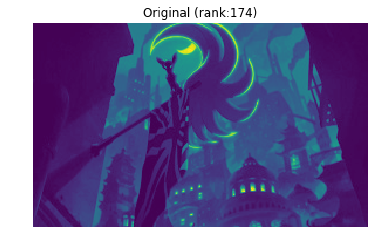

In [7]:
#for the sake of performance
#we use ultra low resolution image
#plot original
plt.imshow(img)
plt.axis('off')
plt.title(f'Original (rank:{np.linalg.matrix_rank(img)})')
plt.show()

### Create Noise

In [8]:
noise_proportion=0.5

In [9]:
#create random noise
mask=np.random.choice(a=[0,1],size=img.shape,
                      p=[noise_proportion,1-noise_proportion])
noisy=np.multiply(img,mask)

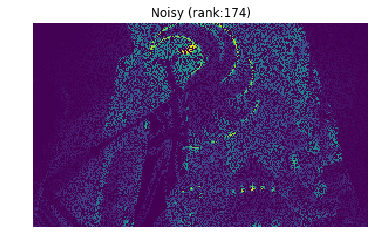

In [10]:
#plot noisy image
plt.imshow(noisy)
plt.axis('off')
plt.title(f'Noisy (rank:{np.linalg.matrix_rank(noisy)})')
plt.show()

### Run

In [11]:
#l1 coefficient
beta=0.9

#admm coefficient
miu=0.05

In [12]:
#find existing input
omega=np.where(mask!=0)

Converged after 1756 iterations


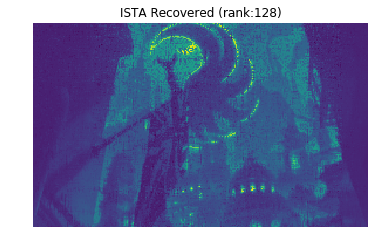

In [13]:
#plot ista recovered image
recs=ista(noisy,omega,beta)
plt.imshow(recs.reshape(img.shape))
plt.axis('off')
plt.title(f'ISTA Recovered (rank:{np.linalg.matrix_rank(recs)})')
plt.show()

Converged after 219 iterations


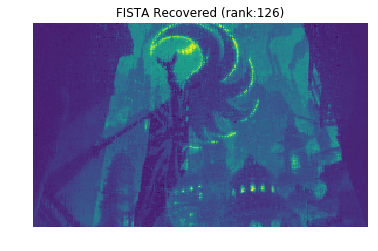

In [14]:
#plot fista recovered image
#fista converges a lot faster than ista
recs=fista(noisy,omega,beta)
plt.imshow(recs.reshape(img.shape))
plt.axis('off')
plt.title(f'FISTA Recovered (rank:{np.linalg.matrix_rank(recs)})')
plt.show()

Converged after 86 iterations


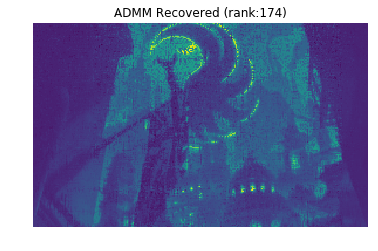

In [15]:
#plot admm recovered image
#admm converges faster than fista
#at the expense of the quality
recs=admm(noisy,omega,beta,miu)
plt.imshow(recs.reshape(img.shape))
plt.axis('off')
plt.title(f'ADMM Recovered (rank:{np.linalg.matrix_rank(recs)})')
plt.show()